## Data Generating for Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression


/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
data = make_regression(n_samples=100, n_features=4, n_informative=2, n_targets=1, 
                        bias=0.0, effective_rank=None,tail_strength=0.5, 
                        noise=10.0, shuffle=True, coef=False, random_state=None)
df1 = pd.DataFrame(data[0],columns=['x'+str(i) for i in range(1,5)])
df1['y'] = data[1]
df1.head()

,x1,x2,x3,x4,y
0,0.314665,-0.809194,-1.074210,0.905985,16.435191
1,0.246512,0.038436,0.876932,1.167722,118.084194
2,-0.771613,-0.072284,-0.576576,1.271385,116.672058
3,-0.063322,-0.842280,0.918615,0.256045,-33.610337
4,0.206178,0.496410,0.008460,-0.720839,-25.604754


In [3]:
X = df1.drop(['y'], axis=1)
y = df1.y

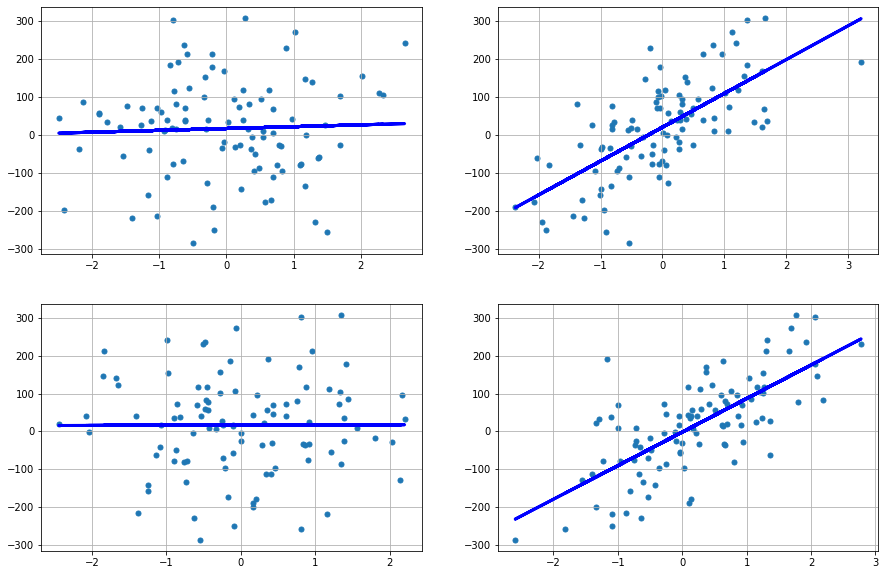

In [4]:
plt.figure(figsize=(15,10))
for i in range(1,5):
    fit = np.polyfit(df1[df1.columns[i-1]],df1['y'],1)
    fit_fn = np.poly1d(fit)
    plt.subplot(2,2,i)
    plt.scatter(df1[df1.columns[i-1]],df1['y'],s=25 )
    plt.plot(df1[df1.columns[i-1]],fit_fn(df1[df1.columns[i-1]]),'b-',lw=3)
    plt.grid(True)

## Cross validation of linear models

Different types of cross-validation that I will explore:
- leave-p-out cross validation
- leave-one-out cross validation
- repeated random sub-sampling
- k-fold cross validation

Measures of fit:
- mean squared error
- root mean squared error
- median absolute deviation

In [5]:
#Lasso linear model to start 
from sklearn import linear_model
from sklearn.model_selection import cross_validate

lasso = linear_model.Lasso()

In [6]:
# Single metric evaluation using cross_validate
cv_results = cross_validate(lasso, X, y, cv=3)
sorted(cv_results.keys())
cv_results['test_score']


array([0.99268806, 0.9940563 , 0.99408404])

In [7]:
# this is the function to generate an array of scores for a given CV method:

def get_score_list(cv):
    scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = svm.SVR(C=100, gamma=0.1, epsilon=.1).fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    return scores


In [8]:
from sklearn.model_selection import LeavePOut
from sklearn import svm
from sklearn.svm import SVR

lpo = LeavePOut(2)

lpo_scores = get_score_list(lpo)


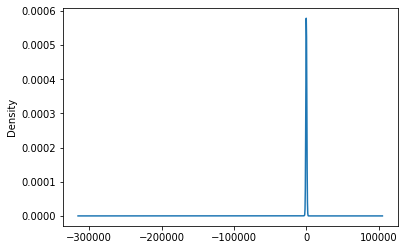

In [9]:
%matplotlib inline
ax = pd.Series(lpo_scores).plot.kde()


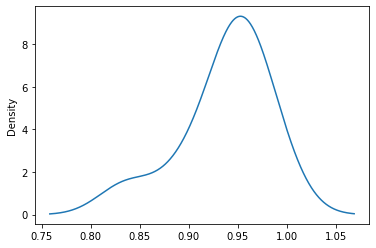

In [16]:
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split

# K-Fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)
# Returns the number of splitting iterations in the cross-validator
kf_scores = get_score_list(kf)

ax = pd.Series(kf_scores).plot.kde()


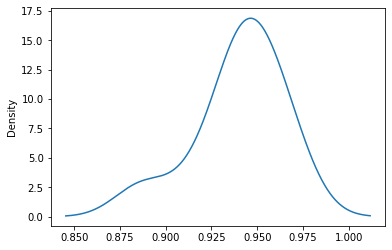

In [12]:
# Montecarlo cross-validation split
mc = ShuffleSplit(n_splits=10, test_size = 0.3 ,random_state=1)
# Returns the number of splitting iterations in the cross-validator
mc.get_n_splits(X)

mc_scores = get_score_list(mc)

ax = pd.Series(mc_scores).plot.kde()


In [21]:
from sklearn.utils import resample, check_random_state

# Single Bootstrap split
a = resample(X)
test = [item for item in X if item not in a]
print("Train:",a,"  Test:",test)

Train:           x1        x2        x3        x4
94  0.638717  1.223086 -0.456100  0.094869
94  0.638717  1.223086 -0.456100  0.094869
54 -0.915883 -0.553094 -0.109120  0.639929
55 -0.557470  0.793751 -1.644188  0.462038
28  0.429564 -0.167109 -0.863729 -0.486305
..       ...       ...       ...       ...
58 -0.978662  0.278748 -0.472725  0.292962
9   1.323956 -1.953535 -0.621494 -0.638267
17  0.808665 -0.504265  0.416853 -0.008764
71  0.364514 -0.998218  0.292659  0.666753
51  0.376823  0.224868  0.000935 -0.276825

[100 rows x 4 columns]   Test: []


In [22]:
class Bootstrap:
    
    '''Bootstrap cross validator.'''
    
    def __init__(self,n_bootstraps=5, random_state=None):
        self.nb = n_bootstraps
        self.rs = random_state
    
    def split(self, X, y=None):
        '''"""Generate indices to split data into training and test set.'''
        rng = check_random_state(self.rs)
        iX = np.mgrid[0:X.shape[0]]
        for i in range(self.nb):
            train = resample(iX, random_state=rng)
            test = [item for item in iX if item not in train]
            yield (train,test)
            

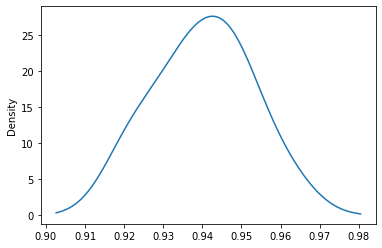

In [24]:
# Bootstrap cross-validator, consistent with similar classes in scikit-learn
boot = Bootstrap(n_bootstraps = 10, random_state=1)
boot_scores = get_score_list(boot)
ax = pd.Series(boot_scores).plot.kde()
    

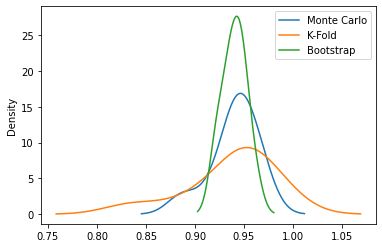

In [25]:
df = pd.DataFrame({
    'Monte Carlo': mc_scores,
    'K-Fold': kf_scores,
    'Bootstrap': boot_scores
})
ax = df.plot.kde()

Sources:
- [Data Generation](https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Synthetic_data_generation/Synthetic-Data-Generation.ipynb)
- [8 Types of Cross-Validation](https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d)
- [K Fold, Montecarlo, and Bootstrap](https://nirpyresearch.com/kfold-montecarlo-cross-validation-bootstrap-primer/)